### Machine Learning Assignment 3, Linear Regression Classes
#### Alexandra Tew 10/31/23

#### 1. Linear regression - Use x and y in linear regression test data.csv for writing and debugging your code. For both of the Python classes you implement, return the intercept θ0, the coefficient θ1, the R2 value, the F statistic and the associated p-value.
(a) (20 points) Implement a Python class to do linear regression using the analytical solution to
least-squared problems.

In [1]:
import numpy as np
from scipy import stats

class LinearRegression:
    
## Use this to call and return the values from the class (i.e. v1, v2, v3 = linearRegression(x,y))
#     def __call__(self):
#         return self.value

    def fit(self, X, y):
        # Add a column of ones to the input data for the intercept term
        X = np.column_stack((np.ones(len(X)), X))
        n, p = X.shape

        # Calculate coefficients
        XTX = np.dot(X.T, X)
        XTy = np.dot(X.T, y)
        self.coefficients = np.linalg.solve(XTX, XTy)

        # Calculate the predicted values
        y_pred = np.dot(X, self.coefficients)

        # Store predicted values as an attribute
        self.y_hat = y_pred

        # Calculate R2 value
        y_mean = np.mean(y)
        ssr = np.sum((y_pred - y_mean) ** 2)
        sst = np.sum((y - y_mean) ** 2)
        self.r2 = ssr / sst

        # Calculate the F-statistic and p-value
        f_stat = (self.r2 / p) / ((1 - self.r2) / (n - p - 1))
        df1 = p
        df2 = n - p - 1
        self.p_value = stats.f.sf(f_stat, df1, df2)

        self.f_stat = f_stat

        # Extract intercept and coefficient values
        self.intercept = self.coefficients[0]
        self.coefficient = self.coefficients[1]

    def predict_all(self, X):
        X = np.column_stack((np.ones(len(X)), X))
        y_pred = np.dot(X, self.coefficients)
        return y_pred

    def predict_X(self, X, y):
        # This method tests the individual predictor significance like in LinReg
        Xmean = np.mean(X)
        ymean = np.mean(y)

        cov = np.cov(X, y, ddof=0)[0, 1]
        var = np.var(X, ddof=0)
        b1hat = cov / var
        b0hat = ymean - b1hat * Xmean

        yhat = b0hat + b1hat * X
        sst = np.sum((y - ymean) ** 2)
        ssr = np.sum((yhat - ymean) ** 2)
        sserr = np.sum((y - yhat) ** 2)
        mst = sst / (len(y) - 1)
        msr = ssr / 1
        mserr = sserr / (len(y) - 2)
        Fstat = msr / mserr
        R2 = ssr / sst
        pvalue = 1.0 - stats.f.cdf(Fstat, 1, len(y) - 2)

        return b0hat, b1hat, R2, Fstat, pvalue, yhat

    def print_results(self):
        print(f'Intercept (θ0): {self.intercept}')
        print(f'Coefficient (θ1): {self.coefficient}')
        print(f'R2 Value: {self.r2}')
        print(f'F Statistic: {self.f_stat}')
        print(f'P-Value: {self.p_value}')
        print(f'Y-hat: {self.y_hat}\n')

In [2]:
# Answer for Question 1, part a

import pandas as pd

# Read the CSV file into a DataFrame
data = pd.read_csv('linear_regression_test_data.csv')

# Set 'x' as the feature (independent variable) and 'y' as the target variable
X = data['x'].values
y = data['y'].values

# Create an instance of the custom linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(X, y)

# Print the results of the overall model significance
print('Overall Model Significance:')
model.print_results()

# Test individual predictor significance
b0, b1, r2, f_stat, p_value, y_hat = model.predict_X(X, y)

# Print individual predictor significance
print(f'Individual Significance of X:')
print(f'Intercept: {b0}')
print(f'Coefficient: {b1}')
print(f'R2: {r2}')
print(f'F Statistic: {f_stat}')
print(f'P-Value: {p_value}')

Overall Model Significance:
Intercept (θ0): 0.024525025871305253
Coefficient (θ1): 1.9340058850010586
R2 Value: 0.9292357328496273
F Statistic: 111.61712043788528
P-Value: 1.672704070528177e-10
Y-hat: [-3.68707675 -3.29395013 -3.16945243 -0.87717413 -0.56608324 -0.45830178
  0.24805681  0.37174239  0.40214744  0.55091935  0.81950492  1.15316532
  1.68923503  2.1763522   2.28131679  2.59767998  2.88694771  3.05529018
  3.31695064  3.61143106]

Individual Significance of X:
Intercept: 0.024525025871305006
Coefficient: 1.9340058850010582
R2: 0.9292357328496267
F Statistic: 236.36566680963762
P-Value: 8.528955319775378e-12


(b) (30 points) Implement a Python class for gradient descent-based linear regression. Use ∆J =
0.00001 as the stopping criterion.

In [3]:
# Python Class for Gradient Descent Linear Regression

import numpy as np
from scipy.stats import f

class GradientDescentLinearRegression:
    def __init__(self, learning_rate=0.01, max_iterations=1000, tolerance=0.00001):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.tolerance = tolerance

    def normalize(self, X):
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        X_normalized = (X - mean) / std
        return X_normalized

    def fit(self, X, y):
        # Normalize the input data
        X = self.normalize(X)

        # Add a column of ones to the input data for the intercept term
        X = np.column_stack((np.ones(len(X)), X))

        n, p = X.shape
        self.coefficients = np.zeros(p)
        prev_cost = np.inf

        for i in range(self.max_iterations):
            y_pred = np.dot(X, self.coefficients)
            error = y_pred - y
            gradient = np.dot(X.T, error) / n
            self.coefficients -= self.learning_rate * gradient

            cost = np.mean(error ** 2)
            if abs(prev_cost - cost) < self.tolerance:
                break
            prev_cost = cost

        # Calculate R2 value
        y_pred = np.dot(X, self.coefficients)
        y_mean = np.mean(y)
        ssr = np.sum((y_pred - y_mean) ** 2)
        sst = np.sum((y - y_mean) ** 2)
        self.r2 = ssr / sst

        # Calculate the F-statistic
        f_stat = ((ssr / p) / ((sst - ssr) / (n - p - 1)))
        self.f_stat = f_stat

        # Calculate the p-value for the F-statistic
        df1 = p
        df2 = n - p - 1
        p_value = f.sf(f_stat, df1, df2)
        self.p_value = p_value

        # Extract intercept and coefficient values
        self.intercept = self.coefficients[0]
        self.coefficient = self.coefficients[1]

    def predict(self, X):
        # Normalize the input data
        X = self.normalize(X)

        # Add a column of ones to the input data
        X = np.column_stack((np.ones(len(X)), X))
        y_pred = np.dot(X, self.coefficients)
        return y_pred

In [4]:
# Read the CSV file into a DataFrame
data = pd.read_csv('linear_regression_test_data.csv')

# Extract the input features (X) and target variable (y)
X = data['x']
y = data['y']

# Create an instance of the class
gdl_regression = GradientDescentLinearRegression()

# Fit the model with test data
gdl_regression.fit(X, y)

In [5]:
# Get the results
intercept = gdl_regression.intercept
coefficient = gdl_regression.coefficient
r2_value = gdl_regression.r2
f_statistic = gdl_regression.f_stat
p_value = gdl_regression.p_value

# Print the results
print(f'Intercept (θ0): {intercept}')
print(f'Coefficient (θ1): {coefficient}')
print(f'R2 Value: {r2_value}')
print(f'F Statistic: {f_stat}')
print(f'P-Value: {p_value}')

Intercept (θ0): 0.6489975393213059
Coefficient (θ1): 2.1135222113594905
R2 Value: 0.9110803568447717
F Statistic: 236.36566680963762
P-Value: 1.1654148423685662e-09


#### 2. PCA and linear regression
(a) (20 points) The data in linear regression test data.csv contains x, y, and y−theoretical.
Perform PCA on x and y using your own PCA class. Plot y vs x, y-theoretical vs x, and the PC1
axis in the same plot.

In [6]:
import matplotlib.pyplot as plt

class MyPCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        cov_matrix = np.cov(X_centered, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        sorted_indices = np.argsort(eigenvalues)[::-1]
        self.components = eigenvectors[:, sorted_indices[:self.n_components]]

    def transform(self, X):
        X_centered = X - self.mean
        return np.dot(X_centered, self.components)

In [7]:
# Extract 'x', 'y', and 'y-theoretical' columns
X = data[['x', 'y']].values
y_theoretical = data['y_theoretical'].values

In [8]:
# Initialize PCA class and fit it to x and y
my_pca = MyPCA(n_components=1)
my_pca.fit(X)

# Transform 'x' and 'y' using your PCA class
X_pca = my_pca.transform(X)

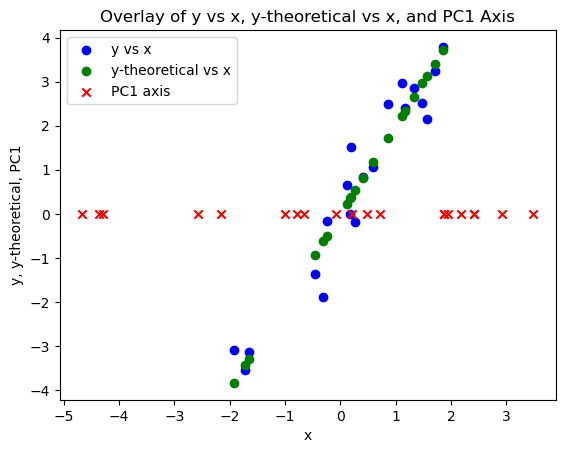

In [9]:
# To plot them all together we can overlay them using this method:

# Create a figure/axis
fig, ax = plt.subplots()

# Plot 'y' vs 'x' in blue
ax.scatter(X[:, 0], X[:, 1], label='y vs x', color='blue')

# Plot 'y-theoretical' vs 'x' in green
ax.scatter(X[:, 0], y_theoretical, label='y-theoretical vs x', color='green')

# Plot the first principal component (PC1) axis in red
ax.scatter(X_pca, np.zeros_like(X_pca), label='PC1 axis', color='red', marker='x')

# Set labels and title
ax.set_xlabel('x')
ax.set_ylabel('y, y-theoretical, PC1')
ax.set_title('Overlay of y vs x, y-theoretical vs x, and PC1 Axis')

# Add a legend
ax.legend()

# Display the plot
plt.show()

(b) (30 points) Perform linear regression on x and y with x being the independent variable and y
being the dependent variable. Plot the regression line in the same plot as you obtained in (1).
Compare the PC1 axis and the regression line obtained above. Are they very different or very
similar? Could you explain why this happens?

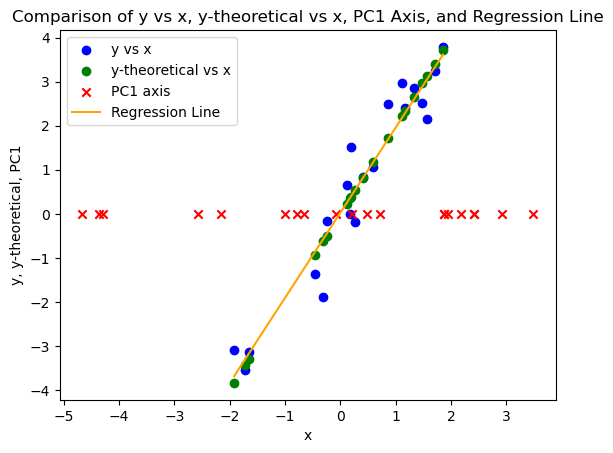

In [78]:
from scipy.stats import linregress

# Linear regression for y as a function of x
slope, intercept, r_value, p_value, std_err = linregress(X[:, 0], X[:, 1])

# Create a figure and axis
fig, ax = plt.subplots()

# Scatter plot of 'y vs x' in blue
ax.scatter(X[:, 0], X[:, 1], label='y vs x', color='blue')

# Scatter plot of 'y-theoretical vs x' in green
ax.scatter(X[:, 0], y_theoretical, label='y-theoretical vs x', color='green')

# Scatter plot of the first principal component (PC1) axis in red
ax.scatter(X_pca, np.zeros_like(X_pca), label='PC1 axis', color='red', marker='x')

# Plot the linear regression line in orange
x_regression = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
y_regression = slope * x_regression + intercept
ax.plot(x_regression, y_regression, label='Regression Line', color='orange')

# Set labels and title
ax.set_xlabel('x')
ax.set_ylabel('y, y-theoretical, PC1')
ax.set_title('Comparison of y vs x, y-theoretical vs x, PC1 Axis, and Regression Line')

# Add a legend
ax.legend()

# Display the plot
plt.show()

The PC1 axis represents the primary direction of data variability, which is predominantly horizontal in this dataset. The regression line which is increasing from left to right indicates a positive linear relationship between x and y. They are similar in the clustering of the data points to one another as they both reflect the data but they do so in very different ways and for unique purposes. They are different in direction as PC1 displays the axis that describes the maximum amount of variance within the data and the regression line shows the linear relationship of the data points directly. The differences can be explained by the two methods offering differing information to the analyst. 